In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie

from source.torch_utils import getContrastiveFeatures

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from source.datasets import loadFuncionalModel, loadNatops, loadWafer, loadSelfRegulationSCP2, loadBasicMotions, loadEarthquakes, loadItalyPowerDemand, loadEigenWorms

dataset = 'italy' # natops | wafer | selfreg | basicmotions | earthquakes | italy | eigenworms

settings = {
    'natops' : {
        'epochs': 150,
        'filters' : [32, 64],
        'kernels' : [5, 5],
        'feat_size' : 256,
        'enc_size' : 20,
    },
    'wafer' : {
        'epochs': 20,
        'filters' : [16, 32],
        'kernels' : [5, 5],
        'feat_size' : 512,
        'enc_size' : 20,
    },
    'basicmotions' : {
        'epochs': 200,
        'filters' : [16, 32],
        'kernels' : [5, 5],
        'feat_size' : 128,
        'enc_size' : 20,
    },
    'italy' : {
        'epochs': 200,
        'filters' : [16],
        'kernels' : [5],
        'feat_size' : 128,
        'enc_size' : 8,
    }
}

if dataset == 'natops':
    X_train, y_train, X_test, y_test, classLabels = loadNatops()
elif dataset == 'wafer':
    X_train, y_train, X_test, y_test = loadWafer()
    classLabels = {}
elif dataset == 'basicmotions':
    X_train, y_train, X_test, y_test, classLabels= loadBasicMotions()
elif dataset == 'italy':
    X_train, y_train, X_test, y_test, classLabels= loadItalyPowerDemand()
# X = np.concatenate([X_train, X_test], axis=0).transpose([0, 2, 1])
# y = np.concatenate([y_train, y_test], axis=0)
# y = np.array([float(v) for v in y]).astype(int).tolist()

In [4]:
mts_train = TSerie(X=X_train.transpose([0, 2, 1]), y=y_train)
mts_test = TSerie(X=X_test.transpose([0, 2, 1]), y=y_test)

Loaded mts - N: 67, T: 24, D: 1 
Loaded mts - N: 1029, T: 24, D: 1 


In [30]:
# mts.smooth(window_size=40)
# mts_train.shapeNormalizization()
# mts_test.shapeNormalizization()
# mts_train.minMaxNormalizization()
# mts_test.minMaxNormalizization()
minl, maxl = mts_train.minMaxNormalizization()
minl, maxl = mts_test.minMaxNormalizization(minl= minl, maxl=maxl)

In [90]:
from source.featlearn.simclr import EncoderCNN, SimClrFL

in_channels = mts_train.D
in_time = mts_train.T
encoder = SimClrFL(in_channels, in_time)

In [91]:
enc = encoder.fit(mts_train.X.transpose([0, 2, 1]))
enc.shape

torch.Size([32, 8])

In [15]:
# mts.folding_features_v2()
# mts.features, _ =  getPeaxFeatures(mts.X.transpose([0, 2, 1]), feat_size = 15, epochs =400, batch_size = 32)
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'shape'
# MODE = 'subsequences'
EPOCHS = settings[dataset]['epochs']
BATCH_SIZE = 64
ENC_SIZE = settings[dataset]['enc_size']
FEAT_SIZE = settings[dataset]['feat_size']
# MODE = 'shape'
mts_train.features, mts_test.features = getContrastiveFeatures(
    mts_train.X.transpose([0, 2, 1]), mts_train.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    head = 'linear',
    X_test=mts_test.X.transpose([0, 2, 1]),
    encoding_size = ENC_SIZE,
    feat_size = FEAT_SIZE,
    conv_filters = settings[dataset]['filters'], 
    conv_kernels = settings[dataset]['kernels'],
)
# getContrastiveFeatures(mts.X, y)

Epoch[1] Train loss    avg: 3.0585336685180664
Epoch[10] Train loss    avg: 1.9147847890853882
Epoch[20] Train loss    avg: 1.6258481740951538
Epoch[30] Train loss    avg: 1.4838871359825134
Epoch[40] Train loss    avg: 1.3747137188911438
Epoch[50] Train loss    avg: 1.5093927383422852
Epoch[60] Train loss    avg: 1.2293577790260315
Epoch[70] Train loss    avg: 1.285077452659607
Epoch[80] Train loss    avg: 1.356519341468811
Epoch[90] Train loss    avg: 1.241120159626007
Epoch[100] Train loss    avg: 1.22439044713974
Epoch[110] Train loss    avg: 1.2281876802444458
Epoch[120] Train loss    avg: 1.1981939673423767
Epoch[130] Train loss    avg: 1.2328932285308838
Epoch[140] Train loss    avg: 1.1514646410942078
Epoch[150] Train loss    avg: 1.1505226492881775
Epoch[160] Train loss    avg: 1.1561101078987122
Epoch[170] Train loss    avg: 1.1440837979316711
Epoch[180] Train loss    avg: 1.1414029598236084
Epoch[190] Train loss    avg: 1.1556047797203064
Epoch[200] Train loss    avg: 1.1445

In [16]:
from sklearn import svm
from sklearn.metrics import f1_score

clf = svm.SVC()
clf.fit(mts_train.features, mts_train.y)

print('accuracy')
print(clf.score(mts_train.features, mts_train.y))
print(clf.score(mts_test.features, mts_test.y))

print('f1 score')
print(f1_score(clf.predict(mts_train.features), mts_train.y, average= 'weighted'))
print(f1_score(clf.predict(mts_test.features), mts_test.y, average= 'weighted'))

accuracy
0.9850746268656716
0.9416909620991254
f1 score
0.9850746268656716
0.9417024182251809


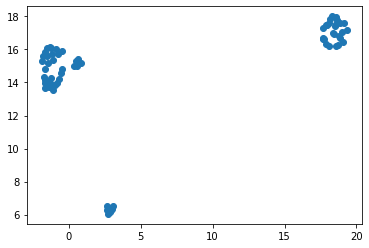

In [17]:
import matplotlib.pyplot as plt
import umap

# reducer = umap.UMAP(n_components=2, metric='cosine')
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=15)
reducer.fit(mts_train.features, y=mts_train.y)
coords_train = reducer.transform(mts_train.features)
coords_test = reducer.transform(mts_test.features)

plt.scatter(coords_train[:, 0], coords_train[:, 1])


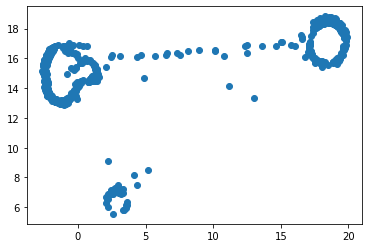

In [18]:
plt.scatter(coords_test[:, 0], coords_test[:, 1])

In [19]:
import sys
sys.path.append('/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

In [20]:
storage = MTSStorage('mts_comparison')    
# storage.delete()
storage.load()

# classLabels = {int(v): str(v) for v in np.unique(y)}
dimensions = [str(dim) for dim in range(mts_train.D)]
# dimensions = [sPoll, sPoll + '_norm']
# dimensions = pollutants + [poll + '_norm' for poll in pollutants]
data = np.concatenate([mts_train.X_orig, mts_train.X], axis=2) 
storage.add_mts(
    '{}_{}_{}_train'.format(dataset, LOSS, MODE),
    data, 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'class': mts_train.y},
    labelsNames = {'class': classLabels},
    coords = {
        'shape': coords_train,
    },
    sampling=True,
    n_samples= 400
)

data = np.concatenate([mts_test.X_orig, mts_test.X], axis=2) 
storage.add_mts(
    '{}_{}_{}_test'.format(dataset, LOSS, MODE),
    data, 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'class': mts_test.y},
    labelsNames = {'class': classLabels},
    coords = {
        'shape': coords_test,
    },
    sampling=True,
    n_samples= 400
)


storage.save()

mts shape: N: 67 -  T: 24 - D: 2
mts shape: N: 1029 -  T: 24 - D: 2
